# Multi-factor: S&P 500 Index Premium <a class="tocSkip">

# Changes
- 4.3.1 加了 shift(1)
- 4.5.6 Turnover analysis
- 4.1 Calculate returns

[Context](https://www.joinquant.com/view/community/detail/8c60c343407d41b09def615c52c8693d?type=1#%E5%9B%9B%E3%80%81%E5%9B%A0%E5%AD%90%E5%A4%9A%E9%87%8D%E5%85%B1%E7%BA%BF%E6%80%A7%E7%9A%84%E5%A4%84%E7%90%86)

In [328]:
import os
import requests
import pandas as pd
import numpy as np
from dateutil.parser import parse
import datetime
from dotenv import load_dotenv, find_dotenv

import statsmodels.api as sm
import scipy
import scipy.stats as stats
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook
import cvxpy as cvx

from pprint import pprint

In [329]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', 20)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)


load_dotenv(find_dotenv(), verbose=True, override=True)

TIINGO_API_TOKEN = os.getenv('TIINGO_API_TOKEN')
DATA_PATH = os.path.expanduser(os.path.abspath(f'../data'))

# Helper Functions

## Tiingo module to get price and fundamental data

In [330]:
__headers = {
    'Content-Type': 'application/json'
}
__token = TIINGO_API_TOKEN

In [331]:
def load_meta() -> str:
    fundamental_meta_data_path = os.path.join(DATA_PATH, 'meta.json')
    with open(fundamental_meta_data_path, 'r') as fp:
        content=fp.read()
    content = json.loads(content)
    return content

In [332]:
def get_price(symbol, start_date=None, end_date=None, resampleFreq='daily'):
    
    start_param = 'startDate={}'.format(start_date) if start_date is not None else ''
    end_param = '&endDate={}'.format(end_date) if end_date is not None else ''
    pricing_daily_url = 'https://api.tiingo.com/tiingo/daily/{}/prices?token={}&{}{}&resampleFreq={}'.format(symbol, __token, start_param, end_param, resampleFreq)

    try:
        pricing_daily_data = requests.get(
            url=pricing_daily_url,
            headers=__headers
        )
    except Exception as e:
        raise(e)
    else:
        if pricing_daily_data.status_code == 200:
            return pricing_daily_data.json()
    print('[{}] "pricing_daily_url" doesn\'t return successfully'.format(symbol))
    return None

In [333]:
def get_daily_fundamental(symbol, start_date=None, end_date=None):
    
    start_param = 'startDate={}'.format(start_date) if start_date is not None else ''
    end_param = '&endDate={}'.format(end_date) if end_date is not None else ''
    fundamental_daily_fundamental_url = 'https://api.tiingo.com/tiingo/fundamentals/{}/daily?token={}&{}{}'.format(symbol, __token, start_param, end_param)
    
    try:
        fundamental_daily_fundamental_data = requests.get(
            url=fundamental_daily_fundamental_url,
            headers=__headers
        )
    except Exception as e:
        raise(e)
    else:
        if fundamental_daily_fundamental_data.status_code == 200:
            return fundamental_daily_fundamental_data.json()
    print('[{}] "fundamental_daily_fundamental_url" doesn\'t return successfully'.format(symbol))
    return None

In [334]:
def get_quarterly_fundamental(symbol, start_date=None, end_date=None):
    
    start_param = 'startDate={}'.format(start_date) if start_date is not None else ''
    end_param = '&endDate={}'.format(end_date) if end_date is not None else ''
    fundamental_quarterly_url = 'https://api.tiingo.com/tiingo/fundamentals/{}/statements?token={}&{}{}'.format(symbol, __token, start_param, end_param)
    
    try:
        fundamental_quarterly_data = requests.get(
            url=fundamental_quarterly_url,
            headers=__headers
        )
    except Exception as e:
        raise(e)
    else:
        if fundamental_quarterly_data.status_code == 200:
            return fundamental_quarterly_data.json()
    print('[{}] "fundamental_quarterly_url" doesn\'t return successfully'.format(symbol))
    return None

In [335]:
def normalize_fundamental_quarterly_data(data):
    """[summary]

    Args:
        data ([type]): [description]

    Returns:
        [type]: [description]
    """
    df = pd.json_normalize(data)

    sheets = [
        'statementData.balanceSheet',
        'statementData.cashFlow',
        'statementData.incomeStatement',
        'statementData.overview'
    ]

    for col in sheets:
        if col not in df.columns:
            continue

        fdf = None
        for i in df.index:
            dic = {}

            if df.iloc[i][col] is np.NaN:
                continue
            for item in df.iloc[i][col]:
                code = None
                value = None
                for k in item.keys():
                    if k == 'dataCode':
                        code = item[k]
                    if k == 'value':
                        value = item[k]
                dic[code] = value
            data = [x for x in dic.values()]
            cols = [col + '.' + x for x in dic.keys()]

            if fdf is None:
                fdf = pd.DataFrame(np.array([data]), index=[i], columns=cols)
            else:
                fdf = fdf.append(pd.DataFrame(np.array([data]), index=[i], columns=cols))
        df = pd.concat([df, fdf], axis=1)
        df = df.drop([col], axis=1)

    df['date'] = df['date'].astype('datetime64[ns]')
    return df

---

## Filter Stocks

In [336]:
def cleanup_stock_list(stock_list) -> list:
    stock_list = [s.lower() for s in stock_list]
    stock_list = [s if s != 'brk.b' else 'brk-b' for s in stock_list]
    stock_list = [s if s != 'bf.b' else 'bf-b' for s in stock_list]
    stock_list = [s if s != 'chk' else 'chkaq' for s in stock_list]
    stock_list = [s if s != 'dps' else 'kdp' for s in stock_list]
    
    # WYN spun-off to WH
    stock_list = [s if s != 'wyn' else 'wh' for s in stock_list]

    # Fundamental not found
    stock_list = [s for s in stock_list if s not in ['frc']]

    # Class B or C
    # goog => googl
    # ua => uaa
    # fox => foxa
    # nws => nwsa
    # disck => disca
    stock_list = [s for s in stock_list if s not in ['ua','fox', 'goog', 'nws', 'disck']]

    # Stock was acquired by another company @ 2018-01-03
    stock_list = [s for s in stock_list if s not in ['bcr']]

    # Stock fundamental is only available before 2018-01-01
    stock_list = [s for s in stock_list if s not in ['csra', 'sni']]
    
    # Symbol changed
    stock_list = [s for s in stock_list if s not in ['dwdp']]
    return stock_list

In [337]:
def get_current_snp_tickers() -> list:
    _header = {
        'authority': 'www.slickcharts.com',
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.146 Safari/537.36'
    }
    
    res = requests.get('https://www.slickcharts.com/sp500', headers=_header)
    snp500_current = pd.read_html(res.content, index_col=0)
    
    # The latest S&P 500 composition (https://www.slickcharts.com/sp500)
    l = snp500_current[0].Symbol.to_list()
    
    return l

In [338]:
def get_snp_stock_scaffolding(start_date, end_date, freq='daily'):
    data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

    # Get current S&P table and set header column
    sp500 = data[0].iloc[1:,[0,1,6,7]]
    columns = ['added_ticker', 'name', 'date', 'cik']
    sp500.columns = columns
    sp500.loc[sp500['date'].isnull(), 'date'] = '1957-01-01'

    # One date is in the wrong format. Correcting it.
    sp500.loc[:,'date'] = sp500.loc[:,'date'].apply(lambda x: datetime.datetime.strptime(x[:10],'%Y-%m-%d'))
    sp500 = pd.melt(sp500, id_vars=['date', 'name', 'cik'], value_vars=['added_ticker'])

    sp500_adjustments = data[1]
    sp500_adjustments = sp500_adjustments[2:].copy()
    columns = ['date', 'added_ticker', 'added_name', 'removed_ticker', 'removed_name', 'reason']
    sp500_adjustments.columns = columns
    updates = sp500_adjustments[~sp500_adjustments['date'].str.contains(',')].T.shift(1).T
    sp500_adjustments['date'].loc[~sp500_adjustments['date'].str.contains(',')] = np.nan
    sp500_adjustments[sp500_adjustments['added_ticker'].isnull()]
    sp500_adjustments.update(updates)
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_additions = sp500_adjustments[~sp500_adjustments['added_ticker'].isnull()]
    sp500_additions = sp500_additions[['date', 'added_ticker', 'added_name']]
    sp500_additions.rename(columns={'added_name': 'name'}, inplace=True)
    sp500_additions = pd.melt(sp500_additions, id_vars=['date','name'], value_vars=['added_ticker'])
    sp500_deletions = sp500_adjustments[~sp500_adjustments['removed_ticker'].isnull()]
    sp500_deletions = sp500_deletions[['date', 'removed_ticker', 'removed_name']]
    sp500_deletions.rename(columns={'removed_name': 'name'}, inplace=True)
    sp500_deletions = pd.melt(sp500_deletions, id_vars=['date','name'], value_vars=['removed_ticker'])
    sp500_history = pd.concat([sp500_deletions, sp500_additions])
    
    df = pd.concat([sp500, sp500_history], ignore_index=True)
    df['date'] = pd.to_datetime(df['date'], utc=True)
    df.sort_values(by='cik', ascending=False, inplace=True)
    deduped_df = df[~df.duplicated(['date', 'variable', 'value'])].copy()    
    deduped_df = deduped_df.sort_values(['date', 'variable']).set_index(['date', 'variable'])

    l = get_current_snp_tickers()
    dictionary = {}

    for d in deduped_df.index.levels[0][::-1]:
        if 'added_ticker' in deduped_df.loc[pd.to_datetime(d),:].index:
            removed_stock_list = [s.upper() for s in deduped_df.loc[(pd.to_datetime(d), 'added_ticker'), 'value'].values]
        else:
            removed_stock_list = []

        if 'removed_ticker' in deduped_df.loc[pd.to_datetime(d),:].index:
            added_stock_list = [s.upper() for s in deduped_df.loc[(pd.to_datetime(d), 'removed_ticker'), 'value'].values]
        else:
            added_stock_list = []

        l = [x.upper() for x in (l + added_stock_list) if x not in removed_stock_list]
        l = list(set(l))
        dictionary[d] = l

        if d <= pd.to_datetime(START_DATE, utc=True):
            break

    if freq == 'daily':
        # Business Day
        re = pd.DataFrame(index=pd.to_datetime(pd.date_range(start_date, end_date, freq = 'B'), utc=True))
    elif freq == 'weekly':
        # business month start frequency
        re = pd.DataFrame(index=pd.to_datetime(pd.date_range(START_DATE,END_DATE, freq = 'BMS'), utc=True))

    re['ticker'] = pd.DataFrame([dictionary]).T
    re = re.ffill().dropna()
    re = re.explode('ticker').reset_index().sort_values(['index', 'ticker'])
    re['ticker'] = re['ticker'].str.lower()
    re = re.set_index(['index', 'ticker'])
    re.index.rename(['date', 'ticker'], inplace=True)
    return re

---

## Fetching data

In [339]:
def download_csv_data(symbol, start_date, end_date=None, freq='daily', path=None):
    '''
    Function for downloading data from Tiingo and storing the results in a CSV file

    Parameters
    ------------
    symbol : str
        The symbol of the assset
    start_date : str
        The start date for downloading the data
    end_date : str
        The end date for downloading the data
    path : str
        The path to store the CSV file
    freq : str
        The frequency of the data
    '''
    df_path=os.path.join(path, f'{symbol}.csv')
    fund_df_path=os.path.join(path, f'{symbol}_fund.csv')
    
    if os.path.exists(df_path):
#         print(f'{symbol}.csv exists')
        return
    
    df = pd.DataFrame(get_price(symbol, start_date, end_date, freq))
    df2 = pd.DataFrame(get_daily_fundamental(symbol, start_date, end_date))
    df3 = normalize_fundamental_quarterly_data(get_quarterly_fundamental(symbol, start_date, end_date))
    df3 = df3[~df3['quarter'].isin([0])]    # Remove the records that quarter = 0
    
    df['date'] = pd.to_datetime(df['date'], utc=True)
    df2['date'] = pd.to_datetime(df2['date'], utc=True)
    df3['date'] = pd.to_datetime(df3['date'], utc=True)

    dd = pd.merge(df, df2, on='date', how='left')
    dd = dd.ffill()
    df3 = df3.ffill()
    df3 = df3[~df3['quarter'].isin([0])]

    dd.to_csv(df_path, header=True, index=True)
    df3.to_csv(fund_df_path, header=True, index=True)
        
    del df
    del df2
    del df3
    del dd

In [340]:
def load_data(symbol, start_date, end_date=None, freq='daily', path=None):
    df_path=f'{path}/{symbol}.csv'
    fund_df_path=f'{path}/{symbol}_fund.csv'
    
    try:
        df = pd.read_csv(df_path, index_col=0)
        fund_df = pd.read_csv(fund_df_path, index_col=0)
    except Exception as e:
        raise(e)
        
    return df, fund_df

## Misc

In [2320]:
def get_cov_by_date(date):
    return np.cov(
        pd.pivot(price_df.loc[(
            slice(
                (pd.to_datetime(date)-datetime.timedelta(days=60)),
                (pd.to_datetime(date))
            ), unoptimize_portfolio.loc[pd.to_datetime(date)]['ticker'].values
        ), :]['adjClose'].reset_index(),
            index='date', 
            columns='ticker', 
            values='adjClose'
        )[-30:].T.values
    )

In [2321]:
def get_optimized_weights(df:pd.DataFrame):
    df_ = df.copy()
    rtn = df_['log_rtn']
    cov = get_cov_by_date(df_.index.get_level_values(0)[0])
    w = cvx.Variable(rtn.shape[0])
    portfolio_variance = cvx.quad_form(w, cov)
    objective = cvx.Minimize(portfolio_variance)
    constraints = [0 <= w, w <= 0.1, sum(w) == 1]
    problem = cvx.Problem(objective, constraints).solve()
    return pd.DataFrame(w.value, index=df_['ticker'].values)

In [2134]:
def list_diff(l1, l2):
    l1 = l1.values[0]
    l2 = l2.values[0]

    l1 = [] if not isinstance(l1,np.ndarray) else list(l1)
    l2 = [] if not isinstance(l2,np.ndarray) else list(l2)
    l = list(set(l1)^set(l2))

    return len(l)

---

# Constucting Factors

## Define factors

### Quality factors

In [341]:
def EPTTM(df, qdf):
    '''
    Description: Reciprocal of pe_ratio TTM (For Trailing Twelve Months)
    Method: Earning / Market Value
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.incomeStatement.eps']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    
    tmp['trailing_eps'] = tmp['statementData.incomeStatement.eps'].rolling(4).mean()

    tmp = pd.merge(df, tmp[['date', 'trailing_eps']], on='date', how='outer').sort_values('date')
    tmp['trailing_eps'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]
    
    tmp['ep_ratio'] = tmp['trailing_eps'] / tmp['adjClose']

    return tmp['ep_ratio']

def SPTTM(df, qdf):
    '''
    Description: Reciprocal of ps_ratio TTM (For Trailing Twelve Months)
    Method: Sales Income / Market Value
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.overview.rps']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    
    tmp['trailing_rps'] = tmp['statementData.overview.rps'].rolling(4).mean()

    tmp = pd.merge(df, tmp[['date', 'trailing_rps']], on='date', how='outer').sort_values('date')
    tmp['trailing_rps'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]
    
    tmp['sp_ratio'] = tmp['trailing_rps'] / tmp['adjClose']

    return tmp['sp_ratio']

def roe_ttm(df, qdf):
    '''
    Description: ROE TTM (For Trailing Twelve Months)
    Method: ROE.mean() for the last 4 seasons
    '''
    qdf.sort_values('date', inplace=True)
    
    field = ['date']
    quarter_field = ['date', 'statementData.overview.roe']
    window = 20
    quarter_window = 4
    
    tmp = qdf[quarter_field].copy(deep=True)
    
    tmp['ROE_TTM'] = tmp['statementData.overview.roe'].rolling(quarter_window).sum()
        
    tmp = pd.merge(df, tmp[['date', 'ROE_TTM']], on='date', how='outer').sort_values('date')
    tmp['ROE_TTM'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['ROE_TTM']

def roa_ttm(df, qdf):
    '''
    Description: ROA TTM (For Trailing Twelve Months)
    Method: ROA.mean() for the last 4 seasons
    '''
    qdf.sort_values('date', inplace=True)
    
    field = []
    quarter_field = ['date', 'statementData.overview.roa']
    window = 20
    quarter_window = 4
    
    tmp = qdf[quarter_field].copy(deep=True)
    
    tmp['ROA_TTM'] = tmp['statementData.overview.roa'].rolling(quarter_window).sum()
        
    tmp = pd.merge(df, tmp[['date', 'ROA_TTM']], on='date', how='outer').sort_values('date')
    tmp['ROA_TTM'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['ROA_TTM']

def book_to_price_ratio(df, qdf):
    '''
    Description: Book to price ratio
    Method: 1 / pbRatio
    '''
    fields = ['date', 'pbRatio']
    
    tmp = df[fields].copy(deep=True)
    tmp['book_to_price'] = (1 / tmp['pbRatio']).shift(1)

    return tmp['book_to_price']

### Growth factors

In [342]:
def SUE0(df, qdf):
    '''
    Description: Standardized unexpected profit
    Method: (actual net profit in one season - expected net profit)/ expected net profit standard deviation
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.incomeStatement.revenue', 'statementData.incomeStatement.costRev']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['net_revenue'] = tmp['statementData.incomeStatement.revenue'] - tmp['statementData.incomeStatement.costRev']
    tmp['previous_quarter'] = tmp['net_revenue'].shift(1)
    tmp['this_quarter_shift_4'] = tmp['net_revenue'].shift(4)
    tmp['previous_quarter_shift_4'] = tmp['previous_quarter'].shift(4)
    tmp['C'] = (tmp['previous_quarter'] - tmp['previous_quarter_shift_4']).rolling(4).mean()
    tmp['epsilon'] = (tmp['previous_quarter'] - tmp['previous_quarter_shift_4']).rolling(4).std()
    tmp['Q'] = tmp['this_quarter_shift_4'] + tmp['C'] + tmp['epsilon']
    tmp['SUE0'] = (tmp['net_revenue'] - tmp['Q']) / tmp['epsilon']
    
    tmp = pd.merge(df, tmp[['date', 'SUE0']], on='date', how='outer').sort_values('date')
    tmp['SUE0'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['SUE0']


def SUR0(df, qdf):
    '''
    Description: Standardized unexpected revenue
    Method: (actual operating income in one season - expected operating income)/ expected operating income standard deviation
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.incomeStatement.opinc']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['previous_quarter'] = tmp['statementData.incomeStatement.opinc'].shift(1)
    tmp['this_quarter_shift_4'] = tmp['statementData.incomeStatement.opinc'].shift(4)
    tmp['previous_quarter_shift_4'] = tmp['previous_quarter'].shift(4)
    tmp['C'] = (tmp['previous_quarter'] - tmp['previous_quarter_shift_4']).rolling(4).mean()
    tmp['epsilon'] = (tmp['previous_quarter'] - tmp['previous_quarter_shift_4']).rolling(4).std()
    tmp['Q'] = tmp['this_quarter_shift_4'] + tmp['C'] + tmp['epsilon']
    tmp['SUR0'] = (tmp['statementData.incomeStatement.opinc'] - tmp['Q']) / tmp['epsilon']
    
    tmp = pd.merge(df, tmp[['date', 'SUR0']], on='date', how='outer').sort_values('date')
    tmp['SUR0'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['SUR0']

def DELTAROE(df, qdf):
    '''
    Description: Quarter-on-quarter ROE change ratio
    Method: ROE this quarter - ROA same quarter last year
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.overview.roe']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['last_year_roe'] = tmp['statementData.overview.roe'].shift(4)
    tmp['DELTAROE'] = tmp['statementData.overview.roe'] - tmp['last_year_roe']

    tmp = pd.merge(df, tmp[['date', 'DELTAROE']], on='date', how='outer').sort_values('date')
    tmp['DELTAROE'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['DELTAROE']


def DELTAROA(df, qdf):
    '''
    Description: Quarter-on-quarter ROA ratio
    Method: ROA this quarter - ROA same quarter last year
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.overview.roa']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['last_year_roa'] = tmp['statementData.overview.roa'].shift(4)
    tmp['DELTAROA'] = tmp['statementData.overview.roa'] - tmp['last_year_roa']

    tmp = pd.merge(df, tmp[['date', 'DELTAROA']], on='date', how='outer').sort_values('date')
    tmp['DELTAROA'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['DELTAROA']

def net_profit_growth_rate(df, qdf):
    '''
    Description: annual net profit growth rate
    Method: (Net profit this year TTM / net profit last year TTM) - 100%
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'year', 'quarter', 'statementData.incomeStatement.revenue', 'statementData.incomeStatement.costRev']
    quarter_window = 4
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['net_profit'] = tmp['statementData.incomeStatement.revenue'] - tmp['statementData.incomeStatement.costRev']
    tmp['net_profit_TTM'] = tmp['net_profit'].rolling(quarter_window).sum()
    tmp['net_profit_TTM_shift_4'] = tmp['net_profit_TTM'].shift(quarter_window)
    tmp['net_profit_growth_rate'] = (tmp['net_profit_TTM'] / tmp['net_profit_TTM_shift_4']) - 1

    tmp = pd.merge(df, tmp[['date', 'net_profit_growth_rate']], on='date', how='outer').sort_values('date')
    tmp['net_profit_growth_rate'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['net_profit_growth_rate']

def operating_revenue_growth_rate(df, qdf):
    '''
    Description: annual operating revenue growth rate
    Method: (operating revenue this year TTM / operating revenue last year TTM) - 100%
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'year', 'quarter', 'statementData.incomeStatement.opinc']
    quarter_window = 4
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['revenue_TTM'] = tmp['statementData.incomeStatement.opinc'].rolling(quarter_window).sum()
    tmp['revenue_TTM_shift_4'] = tmp['revenue_TTM'].shift(quarter_window)
    tmp['total_revenue_growth_rate'] = (tmp['revenue_TTM'] / tmp['revenue_TTM_shift_4']) - 1

    tmp = pd.merge(df, tmp[['date', 'total_revenue_growth_rate']], on='date', how='outer').sort_values('date')
    tmp['total_revenue_growth_rate'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['total_revenue_growth_rate']

def total_profit_growth_rate(df, qdf):
    '''
    Description: annual total revenue growth rate
    Method: (total revenue this year TTM / total revenue last year TTM) - 100%
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'year', 'quarter', 'statementData.incomeStatement.revenue']
    quarter_window = 4
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['profit_TTM'] = tmp['statementData.incomeStatement.revenue'].rolling(quarter_window).sum()
    tmp['profit_TTM_shift_4'] = tmp['profit_TTM'].shift(quarter_window)
    tmp['total_profit_growth_rate'] = (tmp['profit_TTM'] / tmp['profit_TTM_shift_4']) - 1

    tmp = pd.merge(df, tmp[['date', 'total_profit_growth_rate']], on='date', how='outer').sort_values('date')
    tmp['total_profit_growth_rate'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['total_profit_growth_rate']

### Momentum factors

In [343]:
def ILLIQ(df, qdf):
    '''
    Description: illiquidity factor
    Method: mean of the (absolute value of the price change in the past 20 days / trade volume)
    '''
    # ! We should use trading money instead of trading volume.
    # ! Trading money = the money amount that has been traded on the market
    fields = ['adjClose', 'adjVolume']
    window = 20
    tmp = df[fields].copy(deep=True)
    tmp.ffill(inplace=True)
    
    tmp['pct_change'] = df['adjClose'].pct_change()
    tmp['Vol'] = df['adjVolume']
    tmp['pct_vol'] = tmp['pct_change'] / tmp['Vol']
    tmp['ILLIQ'] = tmp['pct_vol'].rolling(window).mean().shift(1)

    return tmp['ILLIQ']

def VOL20(df, qdf):
    '''
    Description: 20-day turnover average
    Method: average of turnover in past 20 days
    '''
    qdf.sort_values('date', inplace=True)
    
    field = ['adjVolume']
    quarter_field = ['date', 'statementData.balanceSheet.sharesBasic']
    window = 20
    tmp = qdf[quarter_field].copy(deep=True)
        
    tmp = pd.merge(df, tmp[['date', 'statementData.balanceSheet.sharesBasic']], on='date', how='outer').sort_values('date')
    tmp['statementData.balanceSheet.sharesBasic'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]
    
    tmp['vol'] = tmp['adjVolume'] / tmp['statementData.balanceSheet.sharesBasic']
    tmp['vol20'] = tmp['vol'].rolling(window).sum().shift(1)

    return tmp['vol20']


def VOL60(df, qdf):
    '''
    Description: 60-day turnover average
    Method: average of turnover in past 60 days
    '''
    field = ['adjVolume']
    quarter_field = ['date', 'statementData.balanceSheet.sharesBasic']
    window = 60
    tmp = qdf[quarter_field].copy(deep=True)
        
    tmp = pd.merge(df, tmp[['date', 'statementData.balanceSheet.sharesBasic']], on='date', how='outer').sort_values('date')
    tmp['statementData.balanceSheet.sharesBasic'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]
    
    tmp['vol'] = tmp['adjVolume'] / tmp['statementData.balanceSheet.sharesBasic']
    tmp['vol60'] = tmp['vol'].rolling(window).sum().shift(1)

    return tmp['vol60']

### Volatility factors

In [344]:
def ATR1M(df, qdf):
    '''
    Description: Average true range of the past month
    Method: Calculate the ATR indicator in the past 20 days
    '''

    fields = ['date','adjHigh', 'adjLow', 'adjClose']
    window = 20
    tmp = df[fields].copy(deep=True)
    tmp.ffill(inplace=True)
    
    tmp['high'] = tmp['adjHigh'].shift(1)
    tmp['low'] = tmp['adjLow'].shift(1)
    tmp['close'] = tmp['adjClose'].shift(1)
    
    tmp['hml'] = tmp['high'] - tmp['low']
    tmp['cmh'] = (tmp['close'].shift(1) - tmp['high']).abs()
    tmp['cml'] = (tmp['close'].shift(1) - tmp['low']).abs()
    
    tmp['TR'] = tmp[['hml', 'cmh', 'cml']].max(axis=1, skipna=False)
    tmp['ATR1M'] = tmp['TR'].rolling(window).mean().shift(1)
    
    return tmp['ATR1M']
    
def ATR3M(df, qdf):
    '''
    
    Description: Average true range of the past three months
    Method: Calculate the ATR indicator in the past 60 days
    '''

    fields = ['date','adjHigh', 'adjLow', 'adjClose']
    window = 60
    tmp = df[fields].copy(deep=True)
    tmp.fillna(0, inplace=True)
    
    tmp['high'] = tmp['adjHigh'].shift(1)
    tmp['low'] = tmp['adjLow'].shift(1)
    tmp['close'] = tmp['adjClose'].shift(1)
    
    tmp['hml'] = tmp['high'] - tmp['low']
    tmp['cmh'] = (tmp['close'].shift(1) - tmp['high']).abs()
    tmp['cml'] = (tmp['close'].shift(1) - tmp['low']).abs()
    
    tmp['TR'] = tmp[['hml', 'cmh', 'cml']].max(axis=1, skipna=False)
    tmp['ATR3M'] = tmp['TR'].rolling(window).mean().shift(1)
    
    return tmp['ATR3M']

### Size factors

In [345]:
def natural_log_of_market_cap(df, qdf):
    '''
    Description: natural of the market capital
    Method: log(marketCap)
    '''
    fields = ['date', 'marketCap']
    
    tmp = df[fields].copy(deep=True)
    tmp['ln_of_market_cap'] = tmp['marketCap'].apply(np.log).shift(1)
                              
    return tmp['ln_of_market_cap']

### Technical factors

In [346]:
def ROC20(df, qdf):
    '''
    Description: Price rate of change in 20 days
    Method: 
        1. AX=today's close - 20 days ago close price
        2. BX=20 days ago close price
        3. ROC=AX/BX*100%
    '''

    fields = ['date', 'adjClose']

    window = 20
    tmp = df[fields].copy(deep=True)
    tmp.fillna(0, inplace=True)
    
    tmp['BX'] = tmp['adjClose'].shift(window)
    tmp['AX'] = tmp['adjClose'] - tmp['BX']
    tmp['ROC20'] = ((tmp['AX'] / tmp['BX'])*100).shift(1)

    return tmp['ROC20']


def ROC60(df, qdf):
    '''
    Description: Price rate of change in 60 days
    Method: 
        1. AX=today's close - 60 days ago close price
        2. BX=60 days ago close price
        3. ROC=AX/BX*100%
    '''

    fields = ['date', 'adjClose']

    window = 60
    tmp = df[fields].copy(deep=True)
    tmp.fillna(0, inplace=True)
    
    tmp['BX'] = tmp['adjClose'].shift(window)
    tmp['AX'] = tmp['adjClose'] - tmp['BX']
    tmp['ROC60'] = ((tmp['AX'] / tmp['BX'])*100).shift(1)

    return tmp['ROC60']

### Fundamental data

In [347]:
def get_market_cap(df, qdf):
    '''
    Description: marketCap directly from financial report
    Method: marketCap
    '''
    fields = ['date', 'marketCap']
                              
    return df['marketCap']

def get_adj_price(df, qdf):
    '''
    Description: close price directly from financial report
    Method: use adjClose price
    '''
    fields = ['adjOpen', 'adjHigh', 'adjLow', 'adjClose']
                              
    return df[fields]

## Constants setup

In [2329]:
START_DATE = '2018-1-1'
END_DATE = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

FREQ = 'daily'
# daily
# weekly
# monthly

USE_ORTHOGONAL_DATA = False

REMOVING_FACTORS = [
# Observing
    'ILLIQ',
    'ATR1M',  
    'ATR3M',
    'total_revenue_growth_rate',
    'ep_ratio',

# Negative impact
    'ROC60',
    'ROC20',
    
# Good for optional for later check
    'SUE0',
    'total_profit_growth_rate',
    'sp_ratio',
    'ln_of_market_cap',
    'ROE_TTM',
    'ROA_TTM',
    'DELTAROE',
    'DELTAROA',
    
# Factor that we are using
#     'net_profit_growth_rate',    
#     'vol60',
#     'SUR0',
#     'vol20',
#     'book_to_price',
]


# 'IC'
# 'IR'
# 'EQUAL'
FACTOR_WEIGHT_METHOD = 'IR'

## Get factors data

### Download raw data

In [527]:
# Needs VPN
snp_scaffolding = get_snp_stock_scaffolding(START_DATE, END_DATE, FREQ)
snp_scaffolding

KeyboardInterrupt: 

In [ ]:
stock_list = cleanup_stock_list(snp_scaffolding.index.levels[1].tolist())

In [ ]:
# Get meta data dataframe
meta_df = pd.json_normalize(load_meta())
meta_df['sicCode'].fillna(0, inplace=True)

# Download data
for symbol in notebook.tqdm(stock_list):
    print(f'Start processing {symbol}...')
    download_csv_data(
        symbol=symbol,
        start_date=START_DATE,
        end_date=END_DATE,
        freq=FREQ,
        path=DATA_PATH
    )

### Construct factors

In [352]:
alpha_factors = [
    ATR1M, ATR3M, ILLIQ, DELTAROA, DELTAROE, SUR0, SUE0, SPTTM, EPTTM,
    natural_log_of_market_cap, book_to_price_ratio, ROC20, ROC60, net_profit_growth_rate, 
    operating_revenue_growth_rate, total_profit_growth_rate, roe_ttm, roa_ttm, VOL20, VOL60
]

risk_factors = [
    get_market_cap, get_adj_price
]

factors = list(set(alpha_factors + risk_factors))

result_df = None

for symbol in notebook.tqdm(stock_list):
    df, dd = load_data(
        symbol=symbol,
        start_date=START_DATE,
        end_date=END_DATE,
        freq=FREQ,
        path=DATA_PATH
    )
            
    tmp = df['date'].copy(deep=True)
    try:
        for func in factors:
            tmp = pd.concat([tmp, func(df, dd)], axis=1)
    except Exception as e:
        print(symbol)
        print(e)
        continue

    try:
        # Need to add .iloc[0] as symbol 'xl' has two sicCode
        tmp['sicCode'] = int(meta_df[meta_df['ticker'] == symbol]['sicCode'].iloc[0])
        tmp['sector'] = meta_df[meta_df['ticker'] == symbol]['sector'].values[0]
        tmp['ticker'] = symbol
        tmp.dropna(axis=0, inplace=True)
    except Exception as e:
        print(symbol)
        display(meta_df[meta_df['ticker'] == symbol]['sicCode'])
        display(meta_df[meta_df['ticker'] == symbol]['sector'])
        raise(e)
    
    if result_df is None:
        result_df = tmp
    else:
        result_df = result_df.append(tmp)

result_df['date'] = pd.to_datetime(result_df['date'], utc=True)
result_df = result_df.sort_values(['date', 'ticker']).set_index(['date', 'ticker'])

result_df.to_csv('/Users/michael/Desktop/result.csv')
print(f'Data has been saved as \'~/Desktop/result.csv\' with shape {result_df.shape}')

vnt
"['statementData.overview.roe'] not in index"

Data has been saved as '~/Desktop/result.csv' with shape (109903, 27)


### Construct pricing data

In [1632]:
price_df = None

for symbol in notebook.tqdm(stock_list):
    df, dd = load_data(
        symbol=symbol,
        start_date=START_DATE,
        end_date=END_DATE,
        freq=FREQ,
        path=DATA_PATH
    )
            
    tmp = df[['date', 'adjClose']].copy(deep=True)
    tmp['ticker'] = symbol
    
    if price_df is None:
        price_df = tmp
    else:
        price_df = price_df.append(tmp)

        
price_df['date'] = pd.to_datetime(price_df['date'], utc=True)
price_df = price_df.sort_values(['date', 'ticker']).set_index(['date', 'ticker'])

price_df.to_csv('/Users/michael/Desktop/price.csv')

price_df

adjClose
date                      ticker            
2018-01-02 00:00:00+00:00 a        65.888699
                          aal      51.648665
                          aap     104.909652
                          aapl     41.440086
                          abbv     84.038250
...                                      ...
2021-02-12 00:00:00+00:00 nktr     22.860000
                          wh       60.200000
2021-02-16 00:00:00+00:00 chkaq     3.050000
                          kdp      31.420000
                          wh       60.700000

[412398 rows x 1 columns]

---

# Preprocessing Data

## Preparation

In [2330]:
# 为不破坏原始数据，先对其进行拷贝
result_df = pd.read_csv('/Users/michael/Desktop/result.csv', index_col=[0,1])

# 获取数据集中的数据名
data_names = [
    'adjOpen', 
    'adjHigh', 
    'adjLow', 
    'adjClose', 
    'marketCap', 
    'sicCode', 
    'sector'
]

# 获取数据集中需测试的因子名
feature_names = [n for n in result_df.columns.tolist() if n not in data_names + REMOVING_FACTORS]

_df = result_df[data_names + feature_names].copy(deep=True)

## Process Null

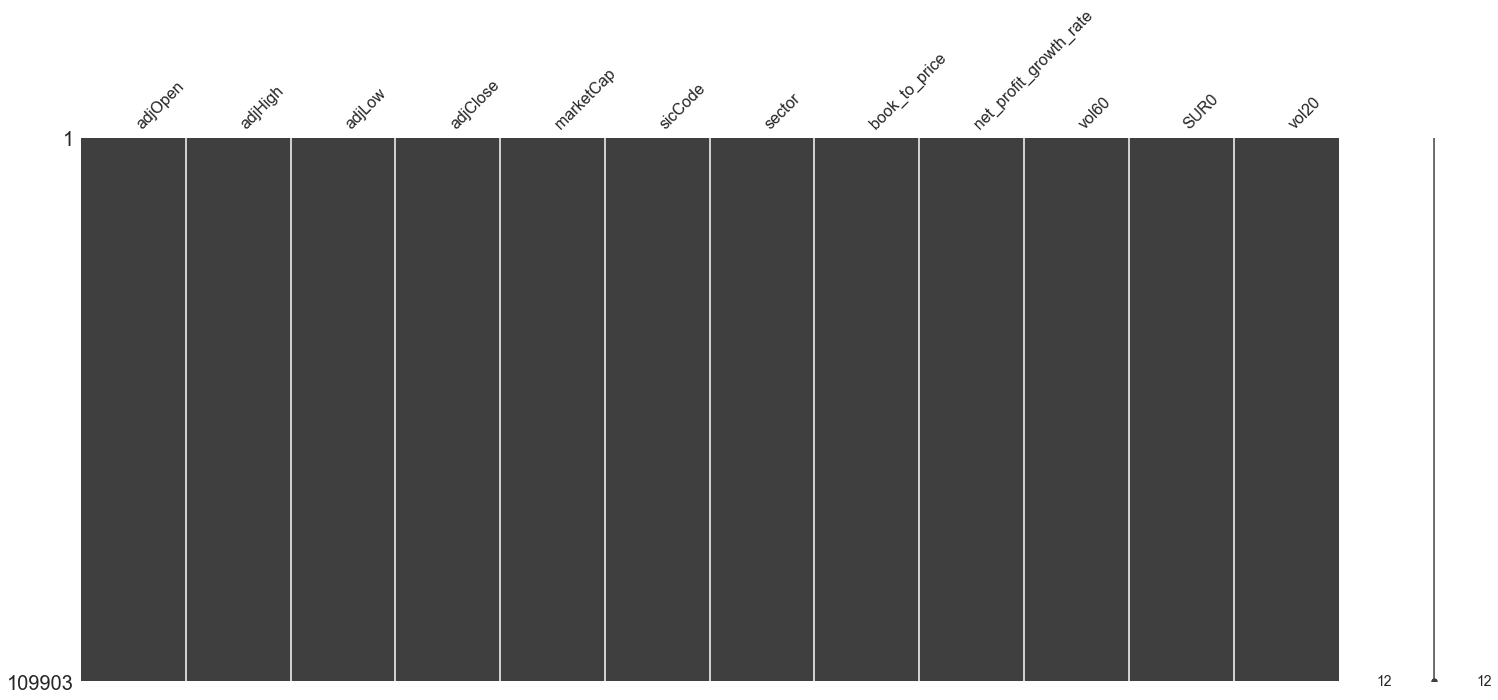

In [2331]:
import missingno as msno
msno.matrix(_df)

## Winsorization
Reference: [Median Absolute Deviation](https://blog.csdn.net/horses/article/details/78749485)

我们采用MAD（Median Absolute Deviation 绝对中位数法）去极值，对于极值部分将其均匀插值到 3-3.5 倍绝对中位数范围内。具体操作如下，首先计算当期所有股票在因子f上的中位数 mf ，然后计算绝对中位数

$$MAD = median(\left\vert {f-mf}\right\vert )$$

采用与 3σ 法等价的方法:
1. 保留$[mf - 3*1.483*MAD, mf + 3*1.483*MAD]$ 之间股票的因子值不变。
2. 取值大于$mf + 3*1.483 * MAD$的所有股票的因子取值按排序均匀压缩到 $[mf+3*1.483*MAD, mf+3.5*1.483*MAD]$ 之间，
3. 取值低于$mf - 3*1.483 * MAD$的所有股票的因子取值按排序均匀压缩到 $[mf−3.5*1.483*MAD, mf−3*1.483*MAD]$ 之间
4. 这样去除了极值同时也在极值的股票之间保序。

In [2332]:
def winsorizae_3_alpha(df: pd.DataFrame, trim: bool=True) -> pd.DataFrame:
    
    median = df.median(axis=0)
    MAD = abs(df.sub(median, axis=1)).median(axis=0)
    MAD_THRESHOLD = 3
    MAD_BOUND = 3.5
    sigma = df.std(axis=0)

    if trim:
        df = df.clip(
            lower=(median - MAD_THRESHOLD * sigma * MAD), 
            upper=(median + MAD_THRESHOLD * sigma * MAD), 
            axis=1
        )

    else:
        upper_lower_range = median + MAD_THRESHOLD * sigma * MAD
        upper_higher_range = median + MAD_BOUND * sigma * MAD
        upper_target_range = upper_higher_range - upper_lower_range
        upper_actual_range = df.max() - upper_lower_range

        udiff = upper_actual_range / upper_target_range

        lower_lower_range = median - MAD_THRESHOLD * sigma * MAD
        lower_higher_range = median - MAD_BOUND * sigma * MAD
        lower_target_range = lower_higher_range - lower_lower_range
        lower_actual_range = df.min() - lower_lower_range

        ldiff = lower_actual_range/lower_target_range

        df = df.mask(
            df > upper_lower_range, 
            (df - upper_lower_range) / udiff + upper_lower_range
        )
        df = df.mask(
            df < lower_lower_range, 
            (df - lower_lower_range) / ldiff + lower_lower_range
        )
    return df
        
_df.loc[:, feature_names] = winsorizae_3_alpha(_df.loc[:, feature_names], trim=False)

---

## Standardization

In [2333]:
_df.loc[:, feature_names] = (
    (
        _df.loc[:, feature_names] - 
        _df.loc[:, feature_names].mean()
    ) / _df.loc[:, feature_names].std()
)

## Neutralization

In [2334]:
# 回归取残差
def calc_resid(x: pd.DataFrame, y: pd.Series) -> float:
    result = sm.OLS(y, x).fit()
    return result.resid

In [2335]:
X = pd.get_dummies(_df['sector'])
X['marketCap'] = np.log(_df['marketCap'])

neutralized_df = pd.concat([calc_resid(X.fillna(0), _df[i]) for i in feature_names], axis=1)
neutralized_df.columns = feature_names

neutralized_df['sicCode'] = _df['sicCode']
neutralized_df['sector'] = _df['sector']
neutralized_df['marketCap'] = _df['marketCap']
neutralized_df['adjOpen'] = _df['adjOpen']
neutralized_df['adjHigh'] = _df['adjHigh']
neutralized_df['adjLow'] = _df['adjLow']
neutralized_df['adjClose'] = _df['adjClose']

---

# Scoring the stocks

## Calculate daily/weekly return

In [2336]:
if USE_ORTHOGONAL_DATA:
    prepared_df = orthogonalized_df.copy(deep=True)
else:
    prepared_df = neutralized_df.copy(deep=True)
    
prepared_df = prepared_df.reset_index()
prepared_df['date'] = pd.to_datetime(prepared_df['date'])
prepared_df.set_index(['date', 'ticker'], inplace=True)

rtn = prepared_df.reset_index()
rtn = pd.pivot(rtn[['date', 'ticker', 'adjClose']], index='date', columns='ticker', values='adjClose')
if FREQ == 'daily':
    rtn = rtn.pct_change()
elif FREQ == 'weekly':
    rtn = rtn.pct_change(5)
elif FREQ == 'monthly':
    rtn = rtn.pct_change(22)
else:
    raise(Exception('Frequency not setting up'))
rtn = rtn.iloc[:-1]
rtn = rtn.stack()
prepared_df['rtn'] = rtn
prepared_df['log_rtn'] = np.log(1 + rtn)

# ----------------------------------------
if FREQ == 'daily':
    pass
elif FREQ == 'weekly':
    idx = [d for d in prepared_df.index.levels[0] if d.isoweekday() == 1]
    prepared_df = prepared_df.loc[idx, :]
elif FREQ == 'monthly':
    idx = [d for d in prepared_df.index.levels[0] if d.day == 1]
    prepared_df = prepared_df.loc[idx, :]
else:
    raise(Exception('Frequency not setting up'))
# ----------------------------------------

prepared_df.to_csv('/Users/michael/Desktop/prepared_data.csv')

In [2337]:
prepared_df = pd.read_csv('/Users/michael/Desktop/prepared_data.csv').sort_values(['date', 'ticker'])
prepared_df['date'] = pd.to_datetime(prepared_df['date'])
prepared_df.set_index(['date', 'ticker'], inplace=True)

## Calculate factor weights in order to calculate final score
We are going to implement three different ways to calculate the weight of factors, in order to calculate our final score:
1. IC weighted
2. IR weighted
3. Equal weighted

In [2338]:
# Required number of sample data per day
N = 200
prepared_df = prepared_df.dropna().groupby(level='date').filter(lambda x: len(x) > N)

### Using IC to calculate the weights for scoring

A股不能做空 所以要取绝对值（不然后面权重计算会有问题） 其次时IC代表的是相关性 正负只是方向 所以有时候看abs（ic） 大于一定的阈值就可以确定ic的有效性了

In [2339]:
IC = prepared_df.groupby(level='date').apply(
    lambda x: [stats.spearmanr(x[factor], x['rtn'], nan_policy='omit')[0] for factor in feature_names]
)

# 计算ic值，得到ic的
IC = pd.DataFrame(IC.tolist(), index=IC.index, columns=feature_names)

# 计算IC的绝对值
IC_abs = IC.abs()

# rolling为移动窗口函数,滚动12个月
rolling_ic = IC_abs.rolling(12, min_periods=1).mean()

# 当滚动计算标准差时，起始日期得到的是缺失值，所以算完权重后，起始日期的值任用原值IC代替
rolling_ic_std = IC_abs.rolling(12, min_periods=1).std()

# 计算IR值
IR = rolling_ic / rolling_ic_std
IR.iloc[0,:] = rolling_ic.iloc[0,:]

In [2340]:
# 计算IR权重,按行求和,按列相除
IR_weights = IR.div(IR.sum(axis=1), axis=0)
IC_weights = IC_abs.div(IC_abs.sum(axis=1), axis=0)

## Scores

### Calculate scores 
`factors5['score'] = (factors5[factor_names].mul(weights.shift())).sum(axis=1)`

> PS: 这里计算分数时：
> 
> **因为计算当期weights时，需要先计算IC值，计算IC值时用到了当期的收益率，所以为了避免未来数据，应该是当期因子值乘以上一期的weights**

In [2341]:
# 计算因子分数
if FACTOR_WEIGHT_METHOD == 'IC':
    prepared_df['score'] = (prepared_df[feature_names].mul(IC_weights.shift())).sum(axis=1)
elif FACTOR_WEIGHT_METHOD == 'IR':
    prepared_df['score'] = (prepared_df[feature_names].mul(IR_weights.shift())).sum(axis=1)
elif FACTOR_WEIGHT_METHOD == 'EQUAL':
    prepared_df['score'] = prepared_df[feature_names].sum(axis=1).shift()

### Exam the correlation between score and returns

In [2342]:
prepared_df[['log_rtn', 'score']].corr('spearman').iloc[1,0]

0.031366517662232724

### Accumulate returns by score groups

In [2343]:
_prepared_df = snp_scaffolding.copy()
_prepared_df['sector'] = prepared_df['sector']
_prepared_df['score'] = prepared_df['score']
_prepared_df['log_rtn'] = prepared_df['log_rtn']
_prepared_df.dropna(inplace=True)
_prepared_df.index = _prepared_df.index.droplevel(1)
_prepared_df.reset_index().drop(columns='date', inplace=True)

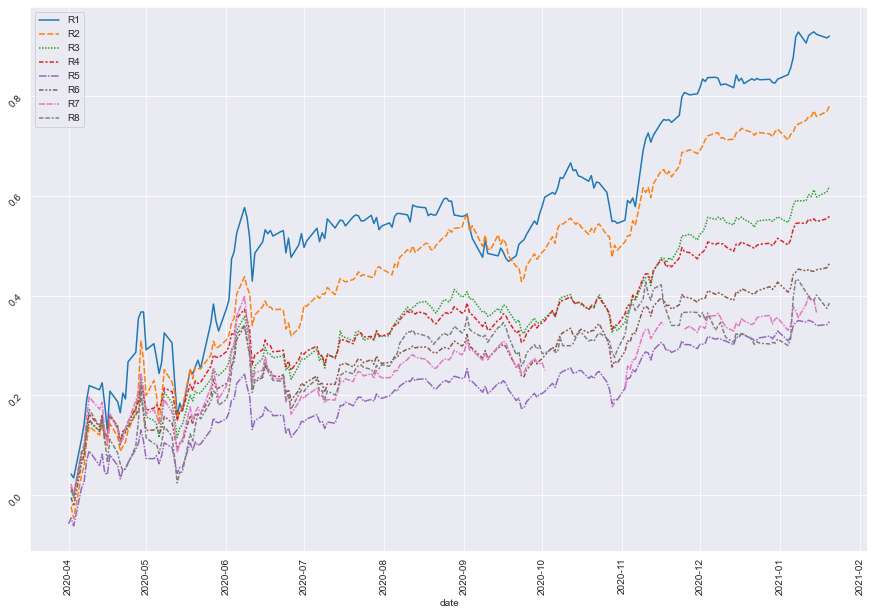

In [2344]:
_prepared_df['rate'] = _prepared_df.groupby('date')['score'].apply(lambda x : pd.cut(x, bins=8, labels=['R8', 'R7', 'R6','R5','R4','R3','R2','R1']))
x = _prepared_df.groupby(['date', 'rate'])['log_rtn'].apply(lambda x: x.sum()/len(x)).reset_index().set_index(['rate', 'date'])
z = pd.DataFrame(index=x.loc['R1'].index)
    
for i in range(1,9):
    z[f'R{i}'] = x.loc[f'R{i}',:].cumsum()
    
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.yticks(rotation=45)

sns.lineplot(data=z)

**Methodology Instruction**
1. Get top N stocks by factor score
2. Evenly weighted
3. Optimization 
  - Objective: to minimize risk
  - Constrain: 
    - Total weight = 1
    - No short

## Implementation
Adjust the data to make sure they fall into the composition of S&P 500 on that day

In [2345]:
adjusted_portfolio = snp_scaffolding.copy()
adjusted_portfolio['score'] = prepared_df['score']
adjusted_portfolio['log_rtn'] = prepared_df['log_rtn']
adjusted_portfolio['marketCap'] = prepared_df['marketCap']

# Get industry weight
adjusted_portfolio['capWeight'] = adjusted_portfolio.groupby('date')['marketCap'].apply(lambda x:x/x.sum())
adjusted_portfolio['weighted_rtn'] = adjusted_portfolio['capWeight'] * adjusted_portfolio['log_rtn']

adjusted_portfolio.dropna(inplace=True)

In [2346]:
TOP_N = 20

final_portfolio = adjusted_portfolio.reset_index().sort_values(['date', 'score'], ascending=[True, False]).set_index(['date']).groupby('date').head(TOP_N)
# Evenly weighted
final_portfolio['weighted_rtn'] = final_portfolio['log_rtn'] / TOP_N
# Cap weighted
# final_portfolio['capWeight'] = final_portfolio.groupby('date')['marketCap'].apply(lambda x:x/x.sum())
# final_portfolio['weighted_rtn'] = final_portfolio['capWeight'] * final_portfolio['log_rtn']

final_portfolio.dropna(inplace=True)

In [2347]:
final_portfolio

,ticker,score,log_rtn,marketCap,capWeight,weighted_rtn
date,,,,,,
2020-04-01 00:00:00+00:00,a,0.000000,-0.038428,2.122544e+10,0.001031,-0.001921
2020-04-01 00:00:00+00:00,aal,0.000000,-0.131307,4.554568e+09,0.000221,-0.006565
2020-04-01 00:00:00+00:00,aapl,0.000000,-0.054052,1.047572e+12,0.050862,-0.002703
2020-04-01 00:00:00+00:00,abbv,0.000000,-0.037034,1.043679e+11,0.005067,-0.001852
2020-04-01 00:00:00+00:00,abc,0.000000,-0.025984,1.752496e+10,0.000851,-0.001299
...,...,...,...,...,...,...
2021-01-20 00:00:00+00:00,dgx,0.709254,0.010815,1.697917e+10,0.000508,0.000541
2021-01-20 00:00:00+00:00,len,0.646242,0.053381,2.446854e+10,0.000732,0.002669
2021-01-20 00:00:00+00:00,wdc,0.644692,-0.003275,1.581770e+10,0.000473,-0.000164


## Performance analysis

### Portfolio return and line chart

In [2348]:
x = final_portfolio.groupby('date').apply(lambda x: x['weighted_rtn'].sum()).cumsum()
benchmark = adjusted_portfolio.reset_index().groupby('date').apply(lambda x: x['weighted_rtn'].sum()).cumsum()
z = pd.DataFrame([x.values, benchmark.values], index=["portfolio", "benchmark"], columns=x.index).T
z['excess_rtn'] = z['portfolio'] - z['benchmark']
z

,portfolio,benchmark,excess_rtn
date,,,
2020-04-01 00:00:00+00:00,-0.059091,-0.044318,-0.014773
2020-04-02 00:00:00+00:00,-0.052592,-0.021553,-0.031039
2020-04-03 00:00:00+00:00,-0.060563,-0.036337,-0.024226
2020-04-06 00:00:00+00:00,0.029612,0.032608,-0.002995
2020-04-07 00:00:00+00:00,0.049621,0.031145,0.018476
...,...,...,...
2021-01-13 00:00:00+00:00,0.799550,0.439105,0.360445
2021-01-14 00:00:00+00:00,0.810032,0.435206,0.374826
2021-01-15 00:00:00+00:00,0.800046,0.428291,0.371755


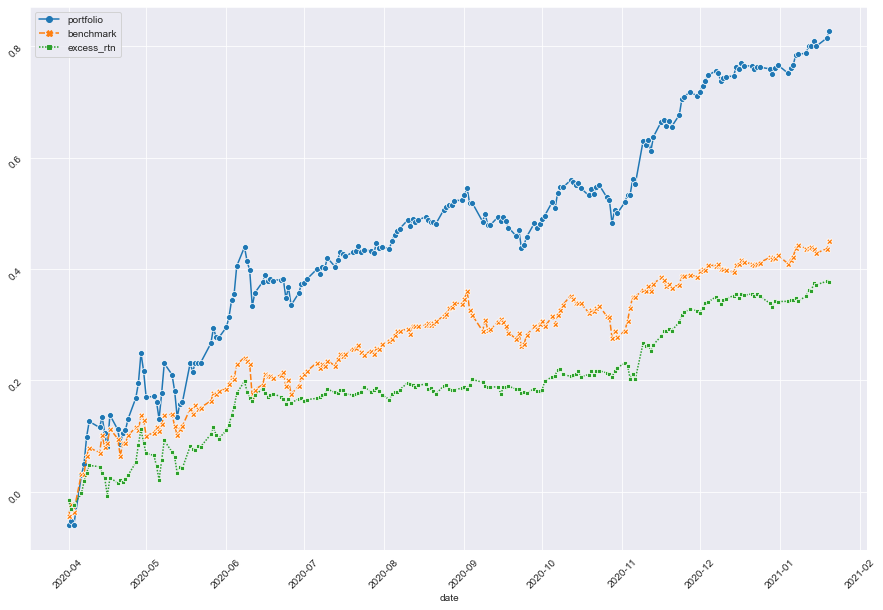

In [2349]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 10))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
sns.lineplot(data=z, markers=True)

### Portfolio performance stats

In [2350]:
ann_factor = 252
variance = z['portfolio'].var() * ann_factor / len(z['portfolio'])

# Show annualized variance
print('Portfolio Variance')
print((variance * 100).round(2), '%')

# Calculate Sharpe Ratio
ann_factor = 252
sharpe_ratio = np.sqrt(ann_factor) * z['excess_rtn'].mean() / z['portfolio'].std()
  
# Show Results
print('Sharpe Ratio')
print(sharpe_ratio.round(2))

win_rate = len(z[z['excess_rtn'] > 0]['excess_rtn']) / z.shape[0]

# Show Win Rate
print('Win Rate')
print(f'{win_rate*100:.3f} %')

x = final_portfolio.groupby('date')['log_rtn'].apply(lambda x: x.sum()).cumsum()
benchmark = adjusted_portfolio.reset_index().groupby('date')['weighted_rtn'].apply(lambda x: x.sum()).cumsum()
z = pd.DataFrame([x.values, benchmark.values], index=["portfolio", "benchmark"], columns=x.index).T

_x = z['benchmark']
_X = sm.add_constant(_x)
_y = z['portfolio']

res = sm.OLS(_y, _X).fit()

alpha, beta = res.params
print(f'alpha is {alpha:.3f}')
print(f'beta is {beta:.3f}')

Portfolio Variance
5.22 %
Sharpe Ratio
14.96
Win Rate
97.537 %
alpha is -0.751
beta is 37.009


### Turnover analysis

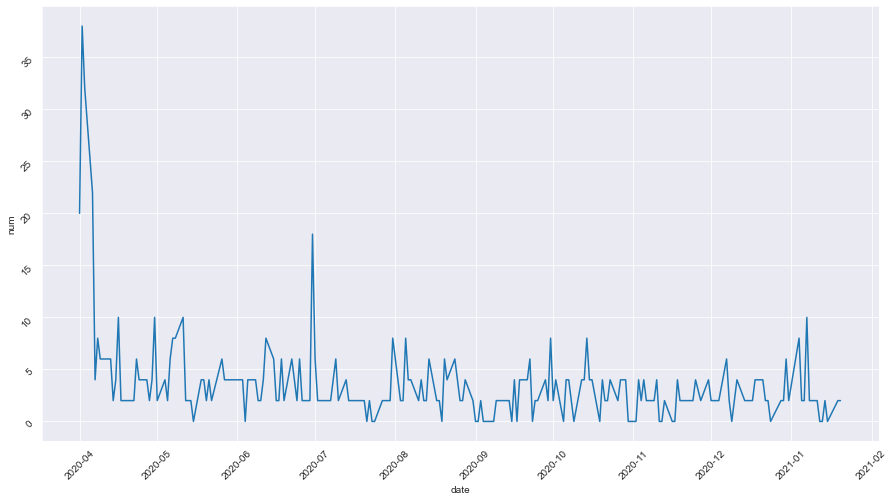

In [2351]:
turnover_df = final_portfolio.groupby('date').apply(lambda x: x.loc[:, 'ticker'].values).to_frame('ticker').copy()
turnover_df['tt'] = turnover_df.shift()
turnover_df['num'] = turnover_df.groupby('date').apply(lambda x: list_diff(x['ticker'], x['tt']))
sns.set_style("darkgrid")
plt.figure(figsize=(15, 8))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
sns.lineplot(data=turnover_df['num'], markers=True)

In [2352]:
turnover = turnover_df['num'].sum()
print(f'Total turnover over time: {turnover}')

Total turnover over time: 730


## Optimization 

### Methodology Instruction

**Objective**
1. Minimize portfolio variance

**Formula**

$x^TPx$

**Constraints**
1. Total weight = 1
2. No short

### Optimization

In [2353]:
unoptimize_portfolio = final_portfolio.copy(deep=True)
adjusted_weights = unoptimize_portfolio.groupby(level='date').apply(get_optimized_weights)

In [2354]:
unoptimize_portfolio = unoptimize_portfolio.reset_index().set_index(['date', 'ticker'])
unoptimize_portfolio['adjWeight'] = adjusted_weights
unoptimize_portfolio['adj_rtn'] = unoptimize_portfolio['log_rtn'] * unoptimize_portfolio['adjWeight']

### Portfolio return and line chart

In [2355]:
x = unoptimize_portfolio.groupby('date')['adj_rtn'].apply(lambda x: x.sum()).cumsum()
benchmark = adjusted_portfolio.reset_index().groupby('date')['weighted_rtn'].apply(lambda x: x.sum()).cumsum()
z = pd.DataFrame([x.values, benchmark.values], index=["portfolio", "benchmark"], columns=x.index).T
z['excess_rtn'] = z['portfolio'] - z['benchmark']
z

,portfolio,benchmark,excess_rtn
date,,,
2020-04-01 00:00:00+00:00,-0.055887,-0.044318,-0.011569
2020-04-02 00:00:00+00:00,-0.059508,-0.021553,-0.037956
2020-04-03 00:00:00+00:00,-0.077433,-0.036337,-0.041096
2020-04-06 00:00:00+00:00,0.025235,0.032608,-0.007373
2020-04-07 00:00:00+00:00,0.049847,0.031145,0.018702
...,...,...,...
2021-01-13 00:00:00+00:00,0.956208,0.439105,0.517103
2021-01-14 00:00:00+00:00,0.962262,0.435206,0.527056
2021-01-15 00:00:00+00:00,0.954833,0.428291,0.526542


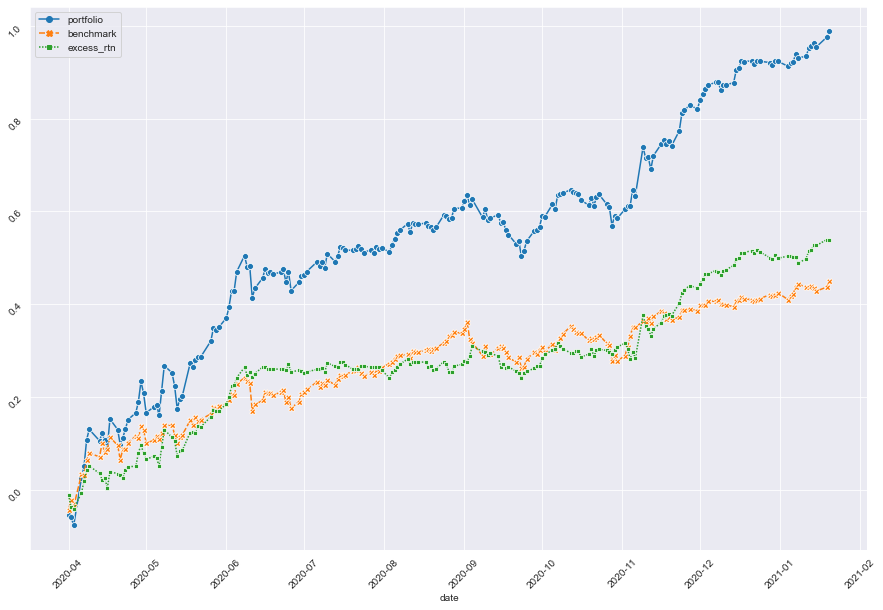

In [2356]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 10))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
sns.lineplot(data=z, markers=True)

### Portfolio performance stats

In [2357]:
ann_factor = 252
variance = z['portfolio'].var() * ann_factor / len(z['portfolio'])

# Show annualized variance
print('Portfolio Variance')
print((variance * 100).round(2), '%')

# Calculate Sharpe Ratio
ann_factor = 252
sharpe_ratio = np.sqrt(ann_factor) * z['excess_rtn'].mean() / z['portfolio'].std()

# Show Results
print('Sharpe Ratio')
print(sharpe_ratio.round(2))

win_rate = len(z[z['excess_rtn'] > 0]['excess_rtn']) / z.shape[0]

# Show Win Rate
print('Win Rate')
print(f'{win_rate*100:.3f} %')

# Show alpha and beta
x = unoptimize_portfolio.groupby('date')['adj_rtn'].apply(lambda x: x.sum()).cumsum()
benchmark = adjusted_portfolio.reset_index().groupby('date')['weighted_rtn'].apply(lambda x: x.sum()).cumsum()
z = pd.DataFrame([x.values, benchmark.values], index=["portfolio", "benchmark"], columns=x.index).T

_x = z['benchmark']
_X = sm.add_constant(_x)
_y = z['portfolio']

res = sm.OLS(_y, _X).fit()

alpha, beta = res.params
print(f'alpha is {alpha:.3f}')
print(f'beta is {beta:.3f}')

Portfolio Variance
7.35 %
Sharpe Ratio
18.03
Win Rate
98.030 %
alpha is -0.045
beta is 2.184


### Turnover analysis

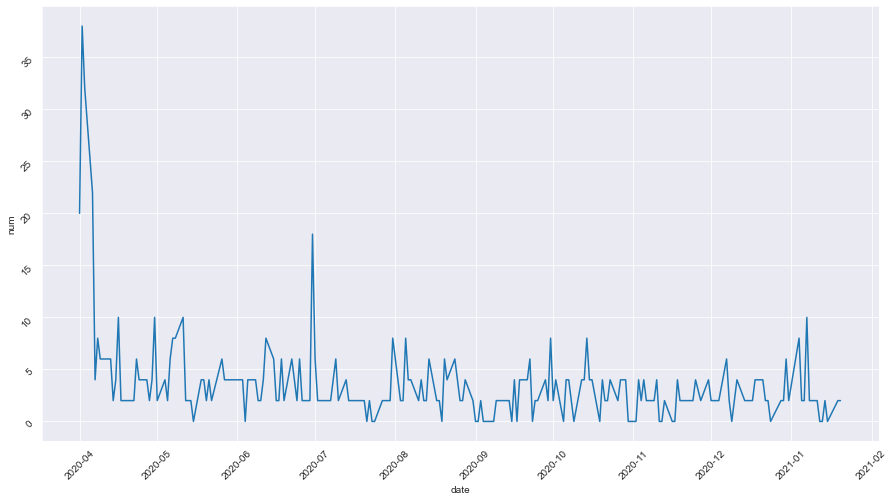

In [2358]:
unoptimize_portfolio = unoptimize_portfolio.reset_index().set_index('date')
turnover_df = unoptimize_portfolio.groupby('date').apply(lambda x: x.loc[:, 'ticker'].values).to_frame('ticker').copy()
turnover_df['tt'] = turnover_df.shift()
turnover_df['num'] = turnover_df.groupby('date').apply(lambda x: list_diff(x['ticker'], x['tt']))
sns.set_style("darkgrid")
plt.figure(figsize=(15, 8))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
sns.lineplot(data=turnover_df['num'], markers=True)

In [2359]:
turnover = turnover_df['num'].sum()
print(f'Total turnover over time: {turnover}')

Total turnover over time: 730


---

# Conclusion

This strategy is profitable with
1. Using factors:
  1. 'net_profit_growth_rate',
  2. 'vol60',
  3. 'SUR0',
  4. 'vol20',
  5. 'book_to_price',
2. Using highest score 10~20 stocks
  1. No orthogonization needed
  2. IR weighted
3. Evenly weighted
4. Run daily
5. Optimization
  1. Objective: 
    1. to minimize risk
  2. Constrain:
    1. Total weight = 1
    2. No short

| | Unoptimized | Optimized|
|:-- | -- | -- |
| Return | 85.9076 % | 98.8302 % |
| Portfolio Variance | 5.51 % | 7.35 %|
|Sharpe Ratio | 16.84 | 18.03 |
| Win Rate | 97.044 % | 98.030 % |